In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Running a WandB Sweep

https://github.com/hep-lbdl/LBL-HEP-ML-training/tree/main/hyperparameter-optimization

## Roadmap

- Dataset description
- Model description
- Hyperparameter description
- Define the sweep config
- Launch a sweep run

# Dataset

The goal here is to distinguish **heavy quark jets** from **light quark/gluon jets**.

This discrimination gives us sensitivity to “interesting” channels (e.g. W, Z, & H bosons) – the kind that win Nobel Prizes

<div class="alert alert-block alert-info">
    A <b>jet</b> is a cone of N <b>constituent</b> particles. We can measure the collective momentum 4-vector, and the distribution of radiation around it.
</div>

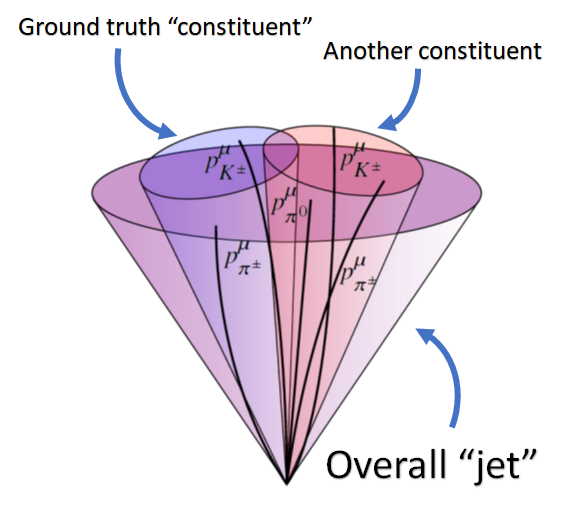

***

Consider 2 constituent particles (a), or 3 constituent particles (b)

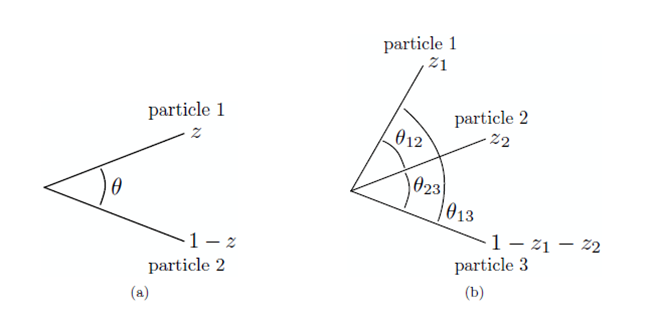

We can define variables that capture the angle between particles and the jet, combined with the unknown momentum contribution.

- For two particles, there are two unknowns
- For three there are five unknowns…
- We use a 16-body set of observables (this is probably overkill!) = **45 ordered observables**, perfect for a **fully-connected network**

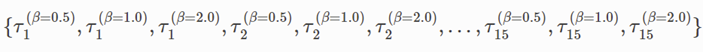

### Loading the Dataset

We use the dataset from https://energyflow.network/docs/datasets/#quark-and-gluon-nsubs, which is based on the original paper by Datta & Larkoski **arXiv:1704.08249v2**

<div class="alert alert-block alert-info">
    We have 100,000 jets, each with 45 N-subjettiness observables and a truth value (1 = quark, 0 = gluon)
    </div>

In [3]:
import energyflow
import torch

In [4]:
all_events = energyflow.qg_nsubs.load(num_data=-1, cache_dir='/global/cscratch1/sd/danieltm/ExaTrkX/quark_gluon_tagging')

In [5]:
dataset = torch.utils.data.TensorDataset(*[torch.from_numpy(tensor) for tensor in all_events])

# Model

Simple fully-connected multi-layer perceptron

```
self.layers = make_mlp(
            input_size = self.hparams["input_channels"],
            sizes = [self.hparams["n_channels"]] * self.hparams["n_layers"] + [1],
            hidden_activation = self.hparams["hidden_activation"],
            output_activation = None,
            layer_norm = self.hparams["layer_norm"],
            batch_norm = self.hparams["batch_norm"],
            dropout = self.hparams["dropout"]
        )
```

# Hyperparameters

### Model HP

- Input channels: `2 - 45`
- Number of MLP layers: `2 - 10`
- Number of hidden channels: `8 - 2048`
- Layer normalisation: `True/False`
- Batch normalisation: `True/False`
- Activation function: `ReLU, SiLU, Tanh`
- Dropout: `0.01 - 0.5`

### Training HP

- Learning rate: `1e-5 - 1e-1`
- Patience (epochs between LR drops): `4 - 25`
- Factor (amount of LR drop): `0.1 - 0.5`
- Weight: `1`
- Maximum epochs: `30`

# Sweep Config

In [1]:
import sys
sys.path.append("../scripts")

from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
from benchmark_model import BenchmarkClassifier
import wandb

In [19]:
# Dataset
sweep_config = {
    "name": "my-little-sweep",
    "metric":  {
        "name": "val_loss",
        "goal": "minimize"
    },
    "method": "grid",
    "parameters": {
        "input_directory": {"values": ['/global/cscratch1/sd/danieltm/ExaTrkX/quark_gluon_tagging']},
        "train_split": {"values": [[80000, 10000, 10000]]},
        "train_batch_size": {"values": [1000]},
        "signal_goal": {"value":[0.5]},
        "input_channels": {"values": [45]},
        "n_channels": {"values":[1024]},
        "layer_norm": {"values":[True]},
        "batch_norm": {"values":[True]},
        "hidden_activation": {"values":["Tanh"]},
        "dropout": {"values":[0.2]},

        # Training hyperparameters
        "lr": {"values":[0.001]},
        "patience": {"values":[15]},
        "factor": {"values":[0.3]},
        "weight": {"values":[1]},
        "edge_cut": {"values":[0.5]},
        "max_epochs": {"values":[3]}
    }
}

In [20]:
sweep_config["parameters"]["n_layers"] =  {"values": [2, 3, 4, 5, 6, 7, 8]}

In [3]:
sweep_id = wandb.sweep(sweep_config, project="HP_Optimization")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: vvc3f72s
Sweep URL: https://wandb.ai/murnanedaniel/HP_Optimization/sweeps/vvc3f72s


## Run the sweep

1. Define train function

2. Pass train function to wandb.agent

Make training script:

In [16]:
# 1. Load in data
def train_model(model, config, run=None):
    
    optimizers, schedulers = model.configure_optimizers()
    optimizer, scheduler = optimizers[0], schedulers[0]["scheduler"]
    
    for epoch in range(config["max_epochs"]):
        
        print("Epoch:", epoch)
        
        for batch in model.train_dataloader():
            
            optimizer.zero_grad()
            
            loss = model.training_step(batch, 0, log=False)
            loss.backward()
            run.log({"train_loss": loss})
            optimizer.step()

        scheduler.step()
        
        for batch in model.val_dataloader():
            
            val_loss = model.shared_evaluation(batch, 0, log=False)["val_loss"]
            run.log({"val_loss": val_loss})

In [17]:
def train():
    with wandb.init() as run:
        config = wandb.config
        model = BenchmarkClassifier(dict(config)).to("cuda")
        model.setup(stage="fit")
        
        train_model(model, config, run)

In [18]:
count = 3 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count)

wandb: Agent Starting Run: wy0dhv6b with config:
wandb: 	batch_norm: True
wandb: 	dropout: 0.2
wandb: 	edge_cut: 0.5
wandb: 	factor: 0.3
wandb: 	hidden_activation: Tanh
wandb: 	input_channels: 45
wandb: 	input_directory: /global/cscratch1/sd/danieltm/ExaTrkX/quark_gluon_tagging
wandb: 	layer_norm: True
wandb: 	lr: 0.001
wandb: 	max_epochs: 3
wandb: 	n_channels: 1024
wandb: 	n_layers: 6
wandb: 	patience: 15
wandb: 	signal_goal: [0.5]
wandb: 	train_batch_size: 1000
wandb: 	train_split: [80000, 10000, 10000]
wandb: 	weight: 1


Epoch: 0
Epoch: 1
Epoch: 2


train_loss,█▅▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▂▁▂▂▁▁▂▂▂▂▂▂▁▁▂▂▂
val_loss,█▄▇▄▇█▇▃▄█▇▂▆▂▆▇▆▂▃▇▇▁▅▂▆▇▇▁▂▇
train_loss,0.47001
val_loss,0.47077


wandb: Agent Starting Run: uexra8fs with config:
wandb: 	batch_norm: True
wandb: 	dropout: 0.2
wandb: 	edge_cut: 0.5
wandb: 	factor: 0.3
wandb: 	hidden_activation: Tanh
wandb: 	input_channels: 45
wandb: 	input_directory: /global/cscratch1/sd/danieltm/ExaTrkX/quark_gluon_tagging
wandb: 	layer_norm: True
wandb: 	lr: 0.001
wandb: 	max_epochs: 3
wandb: 	n_channels: 1024
wandb: 	n_layers: 4
wandb: 	patience: 15
wandb: 	signal_goal: [0.5]
wandb: 	train_batch_size: 1000
wandb: 	train_split: [80000, 10000, 10000]
wandb: 	weight: 1


Epoch: 0
Epoch: 1
Epoch: 2


train_loss,█▂▂▂▂▂▁▂▂▂▂▁▁▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,▃▆▆▄▇▇▆▄██▂▄▅▃▅▆▄▃▅▆▁▄▅▂▄▅▄▂▅▆
train_loss,0.45687
val_loss,0.46739
